# Position-Velocity Diagrams from Disks

## Authors
Adam Ginsburg, Eric Koch

## Learning Goals
* Extract a position-velocity diagram from a spectral cube of a protoplanetary disk using [pvextractor](https://pvextractor.readthedocs.io/en/latest/)
* Extract a position-velocity diagram from a spectral cube of a protoplanetary disk using [reproject](https://reproject.readthedocs.io/en/stable/) via [spectral-cube](http://spectral-cube.readthedocs.io/) using a [region](https://astropy-regions.readthedocs.io/) mask

## Keywords
cube, pv-diagram

## Summary
In this tutorial, we will extract position-velocity (PV) diagrams from a cube of a disk and plot them.

In [104]:
import numpy as np
from astropy.utils.data import download_file
from spectral_cube import SpectralCube

In [105]:
import pylab as pl
# set so that these display properly on black backgrounds
pl.rcParams['figure.facecolor']='w'

In [106]:
import radio_beam

In [107]:
from astropy import units as u

We download a cube from the MAPS survey:

In [108]:
filename = download_file('ftp://ftp.cv.nrao.edu/NRAO-staff/rloomis/MAPS/HD_163296/images/CO/0.15arcsec/HD_163296_CO_220GHz.0.15arcsec.JvMcorr.image.pbcor.fits', cache=True)

We load the cube using the `dask` backend, which allows for some parallelization:

In [109]:
cube = SpectralCube.read(filename, use_dask=True)

In [110]:
cube

DaskSpectralCube with shape=(127, 2048, 2048) and unit=Jy / beam and chunk size (127, 512, 512):
 n_x:   2048  type_x: RA---SIN  unit_x: deg    range:   269.082528 deg:  269.094790 deg
 n_y:   2048  type_y: DEC--SIN  unit_y: deg    range:   -21.961977 deg:  -21.950605 deg
 n_s:    127  type_s: FREQ      unit_s: Hz     range: 230523958206.200 Hz:230543336804.442 Hz

In [111]:
mx = cube.max(axis=0)

A quick look at the image cube shows that there is a disk rotated about 45 degrees in the center of the frame:

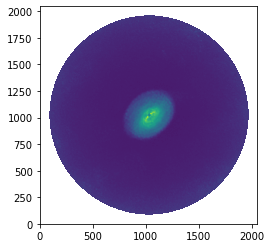

In [112]:
pl.imshow(mx.value, origin='lower')

We can draw an ellipse around the disk to downselect only it:

In [113]:
import regions

In [114]:
center = regions.PixCoord(1024, 1024)
ellipse = regions.EllipsePixelRegion(center, width=550, height=400, angle=45*u.deg)

<AxesSubplot:>

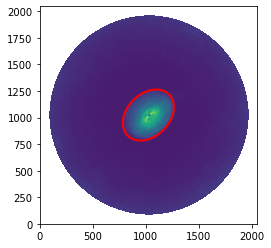

In [115]:
ax = pl.gca()
ax.imshow(mx.value, origin='lower')
ellipse.plot(ax=ax, facecolor='none', edgecolor='red', lw=2)

We make a cutout by creating a subcube using the ellipse region as a mask:

In [116]:
cutout = cube.subcube_from_regions([ellipse])
cutout

DaskSpectralCube with shape=(127, 481, 481) and unit=Jy / beam and chunk size (127, 241, 241):
 n_x:    481  type_x: RA---SIN  unit_x: deg    range:   269.087219 deg:  269.090094 deg
 n_y:    481  type_y: DEC--SIN  unit_y: deg    range:   -21.957622 deg:  -21.954955 deg
 n_s:    127  type_s: FREQ      unit_s: Hz     range: 230523958206.200 Hz:230543336804.442 Hz

Then we want to extract a position-velocity diagram across the disk.

We specify a width of 200 pixels (we could go to ~400) so we average across the short axis of the disk:

In [117]:
import pvextractor

In [118]:
path = pvextractor.Path([(0,0), (481,481)], width=200)

We show the path overlaid on our cutout disk:

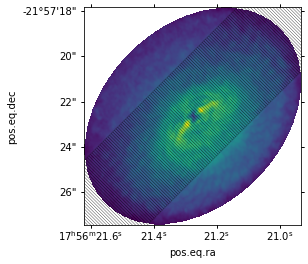

In [119]:
ax = pl.subplot(111, projection=cutout.wcs.celestial)
ax.imshow(cutout.max(axis=0).value, origin='lower')
path.show_on_axis(ax, spacing=5, alpha=0.7, linewidth=0.25)

Then, we extract the PV diagram.  We choose spacing=5 to average over 5 pixels.  This averaging isn't necessary, but does make the operation a little faster and increases the signal-to-noise ratio per spatial bin.

In [120]:
pv = pvextractor.extract_pv_slice(cutout.with_spectral_unit(u.km/u.s, velocity_convention='radio'), path, spacing=5)

And plot the resulting diagram:

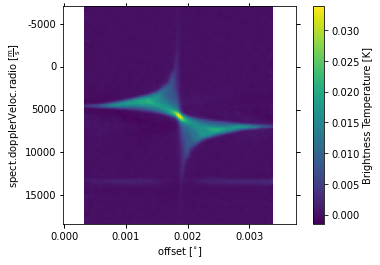

In [129]:
ax = pl.subplot(111, projection=wcs.WCS(pv.header))
im = ax.imshow(pv.data)
cb = pl.colorbar(mappable=im)
cb.set_label("Brightness Temperature [K]")
ax.set_aspect(1)

# Second approach

We can also reproject the whole cube by rotating 45 degrees.

This requires making our own new header, which is a bit tedious, but effective.

In [132]:
header = cutout.wcs.to_header()
header['NAXIS'] = 3
header['NAXIS1'] = 600
header['NAXIS2'] = 400
header['NAXIS3'] = cutout.shape[0]
angle = 45*u.deg
header['CD1_1'] = np.cos(angle).value * np.abs(cube.wcs.wcs.cdelt[0])
header['CD2_1'] = -np.sin(angle).value * np.abs(cube.wcs.wcs.cdelt[0])
header['CD1_2'] = np.sin(angle).value * np.abs(cube.wcs.wcs.cdelt[1])
header['CD2_2'] = np.cos(angle).value * np.abs(cube.wcs.wcs.cdelt[1])
header['CD3_3'] = cube.wcs.wcs.cdelt[2]
header['CRPIX1'] = 300
header['CRPIX2'] = 200

We then reproject the whole cube, which takes a minute or two:

In [133]:
reproj = cutout.reproject(header)

In [134]:
reproj

DaskSpectralCube with shape=(127, 400, 600) and unit=Jy / beam and chunk size (127, 200, 300):
 n_x:    600  type_x: RA---SIN  unit_x: deg    range:   269.086547 deg:  269.090774 deg
 n_y:    400  type_y: DEC--SIN  unit_y: deg    range:   -21.958249 deg:  -21.954328 deg
 n_s:    127  type_s: FREQ      unit_s: Hz     range: 230523958206.200 Hz:230543336804.442 Hz

In [135]:
rmax = reproj.max(axis=0)

INFO: Auto-setting vmin to -2.471e-03 [aplpy.core]
INFO: Auto-setting vmax to  6.055e-02 [aplpy.core]


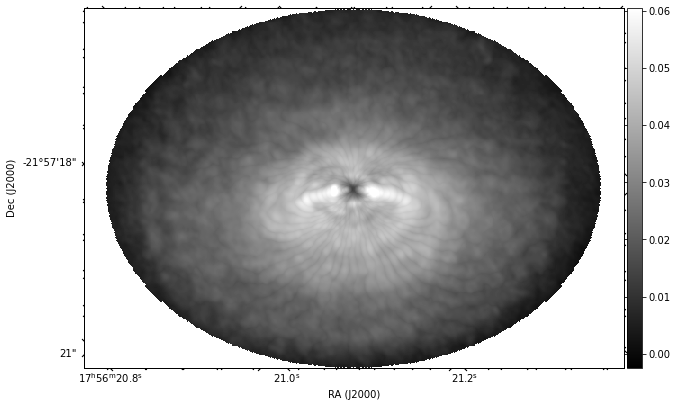

In [136]:
rmax.quicklook()

Then, the position-velocity diagram is easy: we just take the average along the short axis:

In [137]:
pv2 = reproj.with_spectral_unit(u.km/u.s, velocity_convention='radio').mean(axis=1)

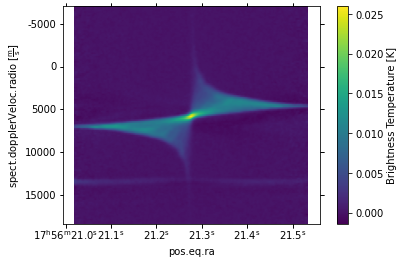

In [138]:
ax = pl.subplot(111, projection=wcs.WCS(pv2.header))
im = ax.imshow(pv2.data)
cb = pl.colorbar(mappable=im)
cb.set_label("Brightness Temperature [K]")
ax.set_aspect(4)